In [1]:
import numpy as np
import scipy.io
import xarray as xr
import os
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import cmocean.cm as cmo

import warnings
warnings.filterwarnings('ignore')

from data_loading import get_altimetry_data, get_2021_CTD_data, get_CTD_all_years, get_CTD, get_LADCP
import warnings

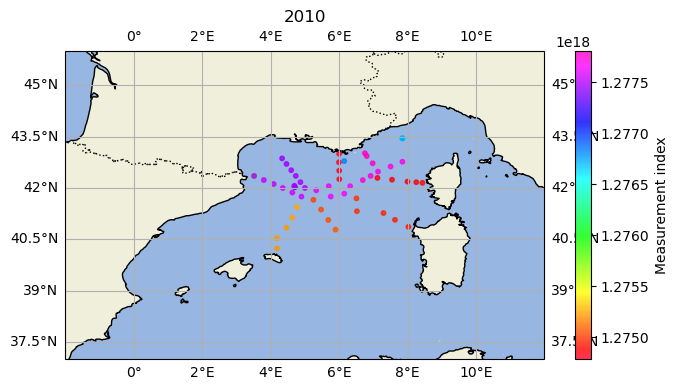

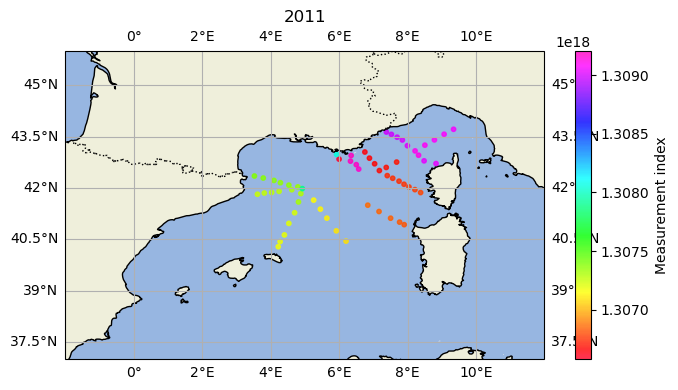

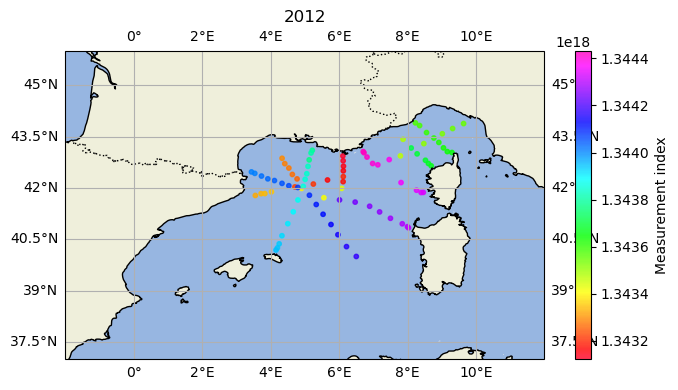

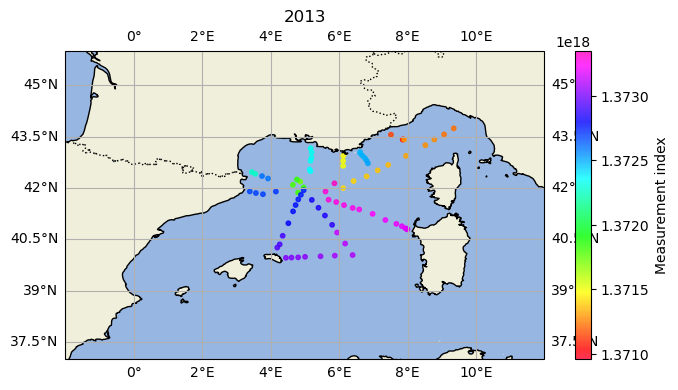

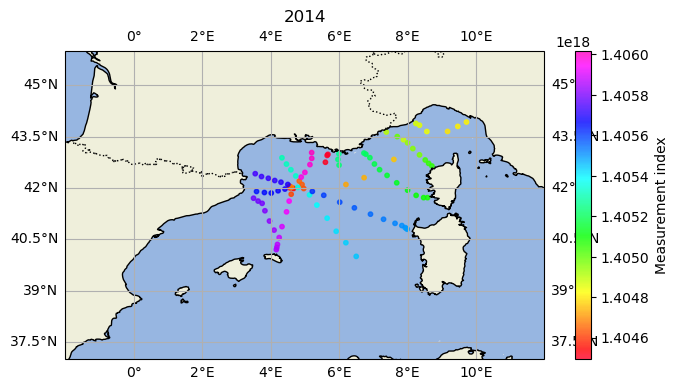

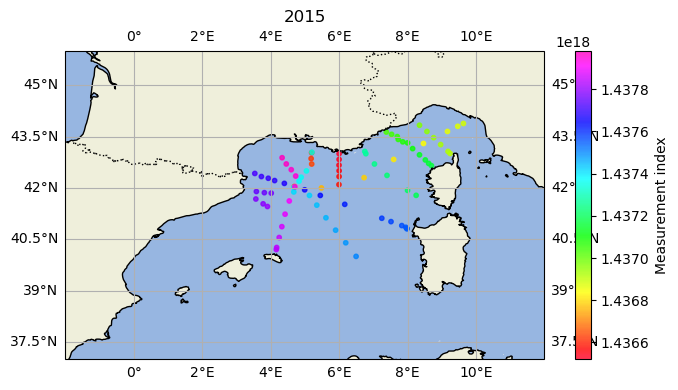

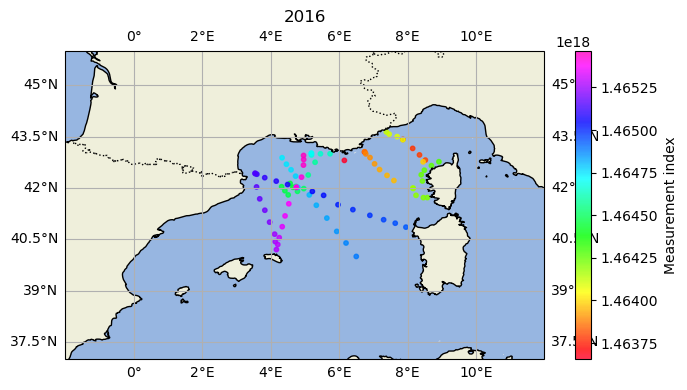

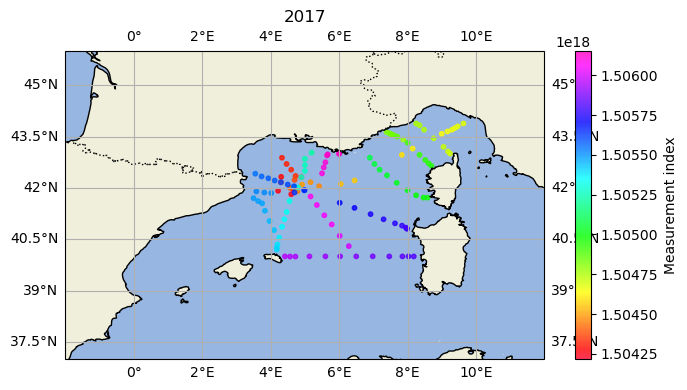

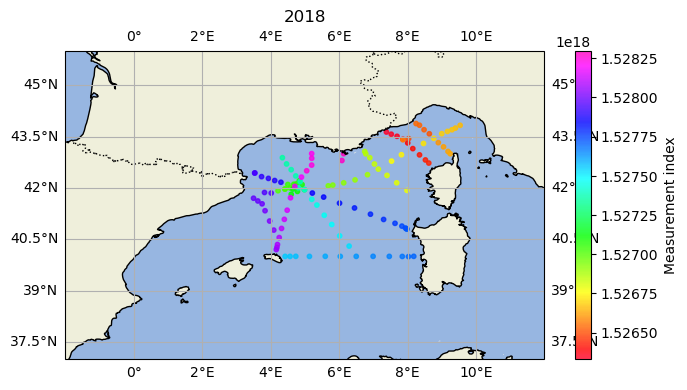

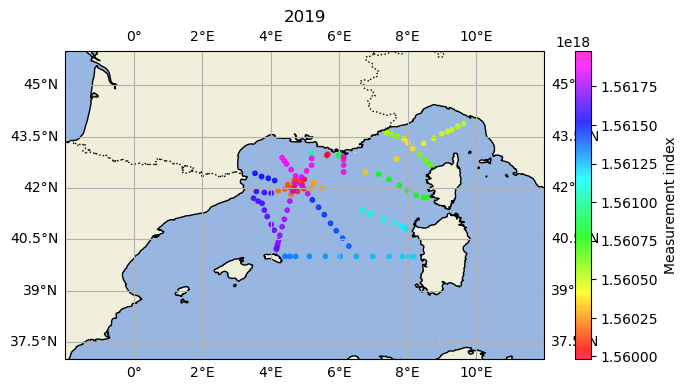

In [2]:
ds = get_CTD_all_years()

years = list(range(2010, 2020))

for year in years:
    ds = get_CTD(year)

    fig, ax = plt.subplots(figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-2, 12, 37, 46])
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(draw_labels=True)
    sc = ax.scatter(ds.longitude, ds.latitude, s=10, c=ds.time, cmap='gist_rainbow', alpha=0.8)
    plt.colorbar(sc, ax=ax, label='Measurement index')
    plt.title(f'{year}')
    plt.show()

    

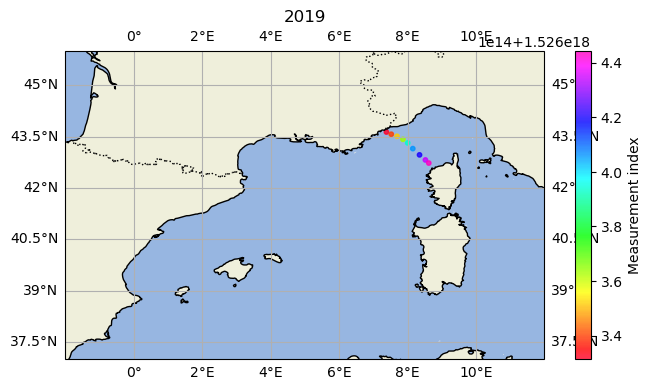

In [3]:
ds = get_CTD(2018).isel(time=slice(0, 9))
fig, ax = plt.subplots(figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
ax.gridlines(draw_labels=True)
sc = ax.scatter(ds.longitude, ds.latitude, s=10, c=ds.time, cmap='gist_rainbow', alpha=0.8)
plt.colorbar(sc, ax=ax, label='Measurement index')
plt.title(f'{year}')
plt.show()

In [4]:
ds

<xarray.Dataset>
Dimensions:      (time: 9, depth: 2901)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-14T20:57:03.666668 ... 2018-05...
  * depth        (depth) float64 0.0 0.9921 1.984 ... 2.856e+03 2.857e+03
    idx          (time) int64 0 1 2 3 4 5 6 7 8
    latitude     (time) float64 43.63 43.57 43.51 43.42 ... 42.97 42.82 42.73
    longitude    (time) float64 7.382 7.525 7.693 7.866 ... 8.35 8.522 8.621
Data variables:
    temperature  (time, depth) float64 nan nan 17.52 17.52 ... nan nan nan nan
    salinity     (time, depth) float64 nan nan 37.89 37.89 ... nan nan nan nan

In [5]:
ds['density'] = gsw.sigma0(ds.salinity, ds.temperature)

In [6]:
proj = ccrs.Mercator(central_longitude=4.5, min_latitude=38.0, max_latitude=45.0)

def show_section(ds, ds_LADCP=None):

    ds = ds.sortby('latitude')

    R = 6371e3 # Earth radius in meters
    ds['x'] = np.radians(ds.longitude - ds.longitude.mean()) * R * np.cos(np.radians(ds.latitude.mean()))
    ds['y'] = np.radians(ds.latitude - ds.latitude.mean()) * R

    x_0 = ds.x.values[0]
    y_0 = ds.y.values[0]
    x_1 = ds.x.values[-1]
    y_1 = ds.y.values[-1]

    t_x = x_1 - x_0
    t_y = y_1 - y_0
    norm_t = np.sqrt(t_x**2 + t_y**2)
    t_x /= norm_t
    t_y /= norm_t

    n_x = -t_y
    n_y = t_x

    ds['distance'] = np.sqrt((ds.x - x_0)**2 + (ds.y - y_0)**2)

    # Trajectory on a map
    fig, ax = plt.subplots(figsize=(10,4), subplot_kw={'projection': proj})
    ax.set_extent([-2, 12, 37, 46])
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    sc = ax.scatter(ds.longitude, ds.latitude, s=10, c=ds.distance / 1e3, cmap='jet', alpha=0.8, transform=ccrs.PlateCarree())
    plt.colorbar(sc, ax=ax, label='Distance [km]')
    plt.title(f'Section')
    plt.show()

    ds['density'] = gsw.sigma0(ds.salinity, ds.temperature)

    levels = 70

    D = ds['density'].values
    min_density = np.nanmin(D)
    max_density = np.nanmax(D)

    fig, ax = plt.subplots(figsize=(10,5))
    cmesh = ax.contourf(
        ds.distance / 1e3, 
        ds.depth, 
        ds['temperature'].T, 
        cmap=cmo.thermal,
        levels=levels
    )
    plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
    cont = ax.contour(
        ds.distance / 1e3, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 10)
    )
    ax.invert_yaxis()
    plt.clabel(cont, fmt='%1.1f')
    plt.xlabel('Distance [km]')
    plt.ylabel('Depth [m]')
    plt.title('CTD measurements')
    plt.show()


    fig, ax = plt.subplots(figsize=(10,5))
    cmesh = ax.contourf(
        ds.distance / 1e3, 
        ds.depth, 
        ds['salinity'].values.T, 
        cmap=cmo.haline,
        levels=levels
    )
    plt.colorbar(cmesh, ax=ax, label='Salinity [g/kg]')
    cont = ax.contour(
        ds.distance / 1e3, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 10)
    )
    ax.invert_yaxis()
    plt.clabel(cont, fmt='%1.1f')
    plt.xlabel('Distance [km]')
    plt.ylabel('Depth [m]')
    plt.title('CTD measurements')
    plt.show()


    fig, ax = plt.subplots(figsize=(10,5))
    cmesh = ax.contourf(
        ds.distance / 1e3, 
        ds.depth, 
        ds['density'].values.T, 
        cmap=cmo.dense,
        levels=levels
    )
    plt.colorbar(cmesh, ax=ax, label='Density [g/kg]')
    cont = ax.contour(
        ds.distance / 1e3, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 10)
    )
    ax.invert_yaxis()
    plt.clabel(cont, fmt='%1.1f')
    plt.xlabel('Distance [km]')
    plt.ylabel('Depth [m]')
    plt.title('CTD measurements')
    plt.show()

    drhodx = np.empty((len(ds.distance)-1, len(ds.depth)))
    dist_centroids = (ds.distance.values[1:] + ds.distance.values[:-1]) / 2
    for i in range(len(ds.distance)-1):
        drhodx[i, :] = (ds['density'].values[i+1, :] - ds['density'].values[i, :]) / float((ds.distance[i+1] - ds.distance[i]))


    fig, ax = plt.subplots(figsize=(10,5))
    D = ds['density'].values
    min_density = np.nanmin(D)
    max_density = np.nanmax(D)
    cmesh = ax.contourf(
        dist_centroids / 1e3, 
        ds.depth, 
        drhodx.T, 
        cmap=cmo.balance,
        vmin = -np.nanmax(abs(drhodx)),
        vmax = np.nanmax(abs(drhodx)),
        levels=100
    )
    plt.colorbar(cmesh, ax=ax, label='Density gradient [g/kg/m]')
    cont = ax.contour(
        ds.distance / 1e3, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 10)
    )
    ax.invert_yaxis()
    plt.clabel(cont, fmt='%1.1f')
    plt.xlabel('Distance [km]')
    plt.ylabel('Depth [m]')
    plt.show()

    g = 9.81
    omega = 2 * np.pi / 24 / 3600
    f = 2 * omega * np.sin(np.radians(float(ds.latitude.mean())))

    rho_0 = 1025. # kg/m^3

    dudz = - g/f * drhodx / rho_0  # or -

    z = ds.depth.values

    u = np.zeros_like(drhodx)
    u[:, -1] = 0
    for i in range(len(ds.depth)-2,-1,-1):
        u[:,i] = u[:,i+1] + dudz[:, i] * (z[i+1]-z[i])


    fig, ax = plt.subplots(figsize=(10,5))
    cmesh = ax.contourf(
        dist_centroids / 1e3, 
        ds.depth, 
        u.T, 
        cmap=cmo.balance,
        levels=np.linspace(-np.nanmax(abs(u)), np.nanmax(abs(u)), 100)
    )

    plt.colorbar(cmesh, ax=ax, label='Cross-section velocity [m/s]')
    cont = ax.contour(
        ds.distance / 1e3, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 10)
    )
    ax.invert_yaxis()
    plt.clabel(cont, fmt='%1.1f')
    plt.xlabel('Distance [km]')
    plt.ylabel('Depth [m]')
    plt.title('Thermal wind results')
    plt.show()

    if ds_LADCP is not None:
        ds_LADCP = ds_LADCP.sortby('latitude')

        cross_section_current = n_x * ds_LADCP['U'].values.T + n_y * ds_LADCP['V'].values.T

        fig, ax = plt.subplots(figsize=(10,5))
        cmesh = ax.contourf(
            ds.distance / 1e3, 
            ds_LADCP.depth, 
            cross_section_current,
            cmap=cmo.balance,
            levels=np.linspace(-np.nanmax(abs(cross_section_current)), np.nanmax(abs(cross_section_current)), 100)
        )
        plt.colorbar(cmesh, ax=ax, label='Cross-section velocity [m/s]')
        ax.invert_yaxis()
        plt.clabel(cont, fmt='%1.1f')
        plt.xlabel('Distance [km]')
        plt.ylabel('Depth [m]')
        plt.title('LADCP measurements')
        plt.show()



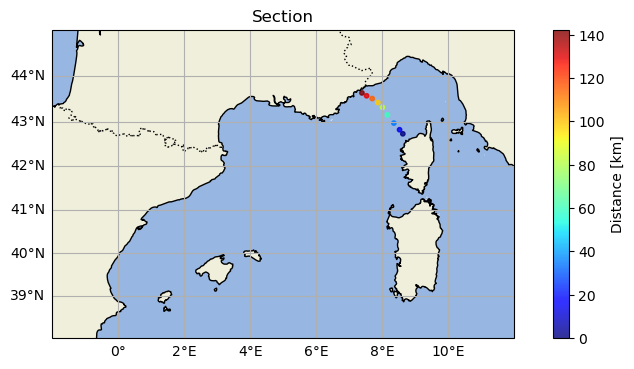

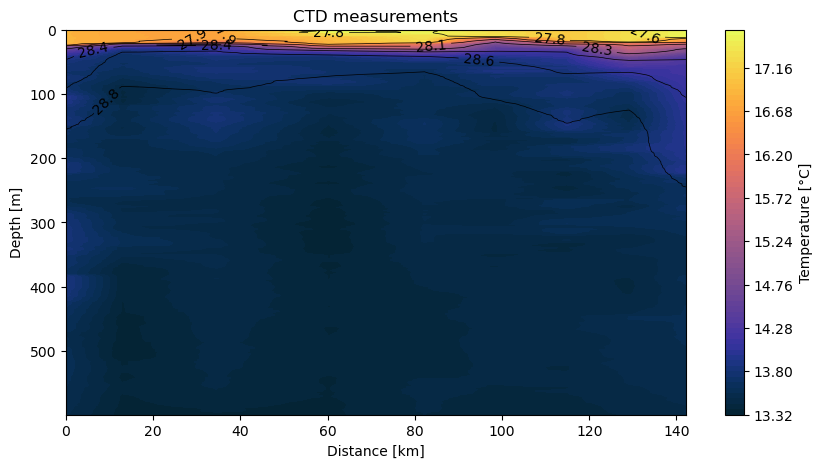

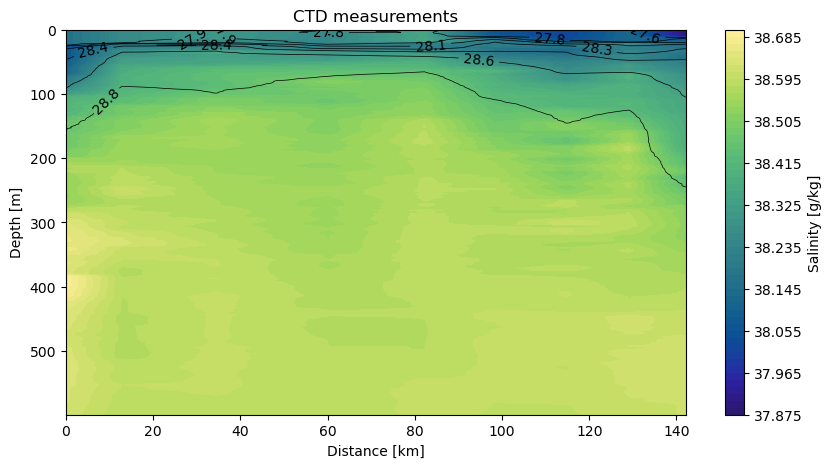

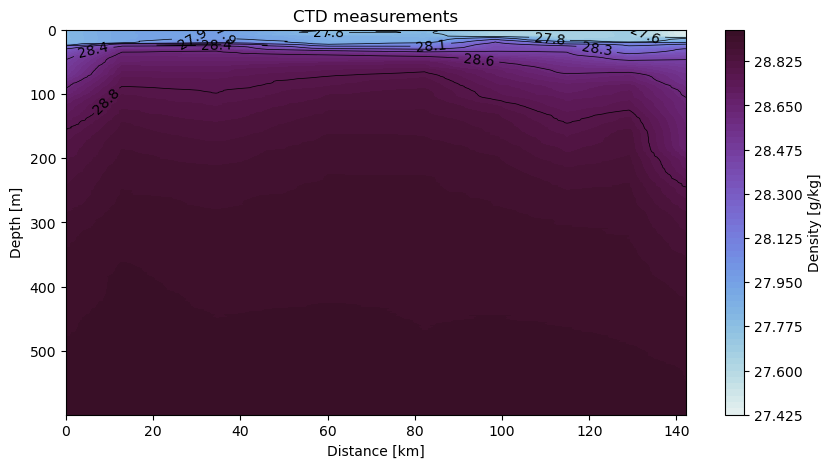

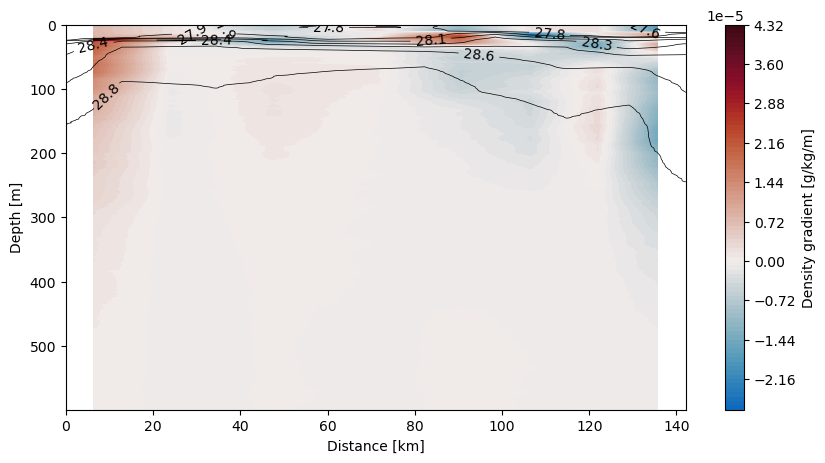

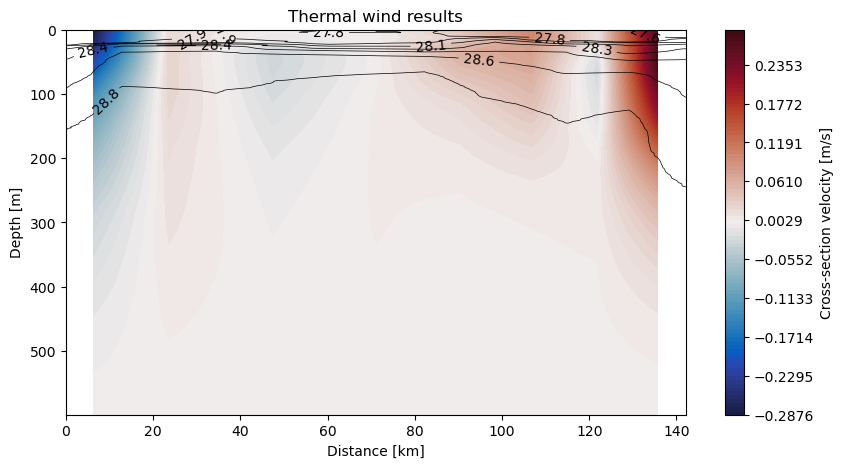

In [7]:
ds = get_CTD(2018).isel(time=slice(0, 9)).sel(depth=slice(0, 600))
show_section(ds)

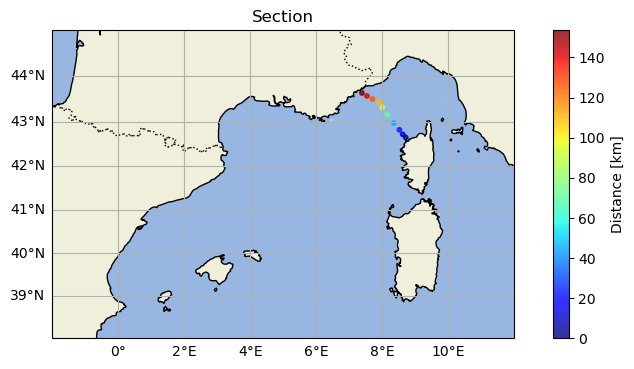

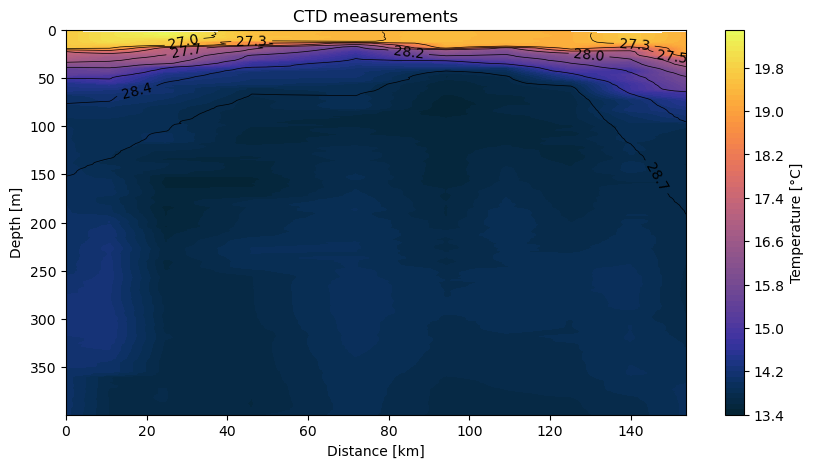

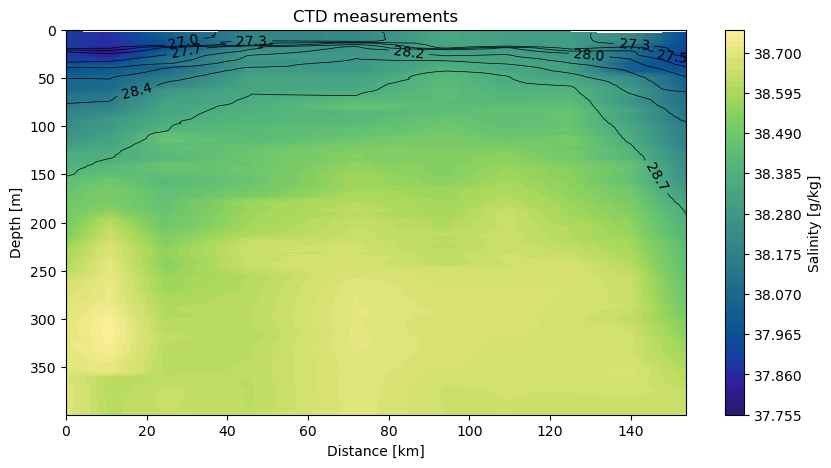

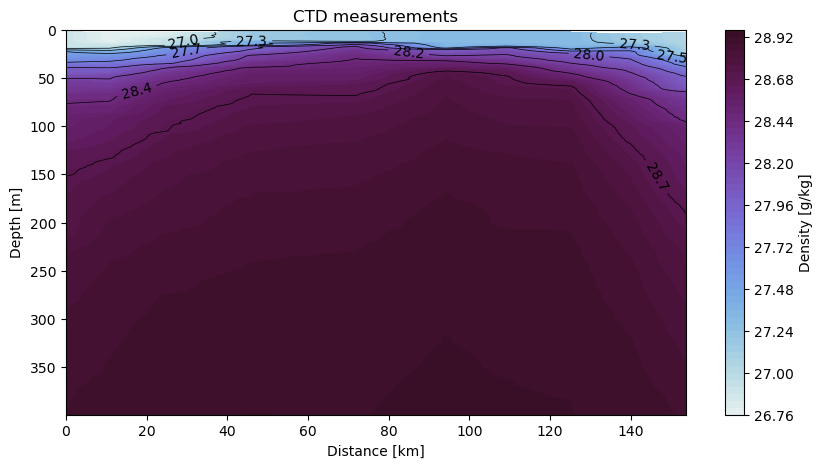

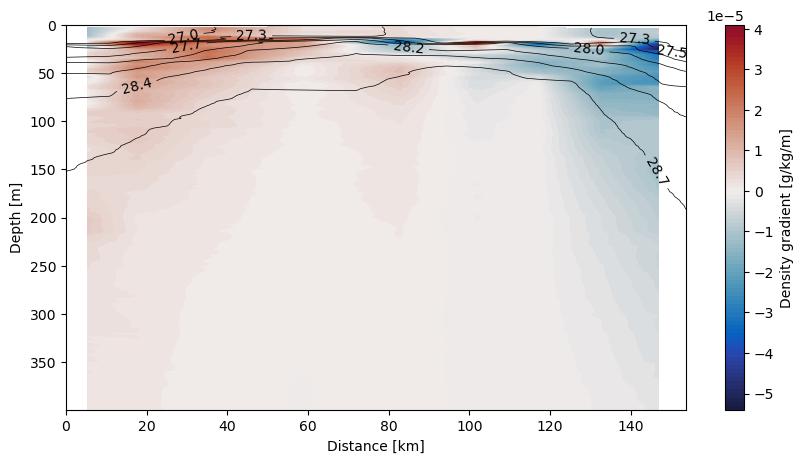

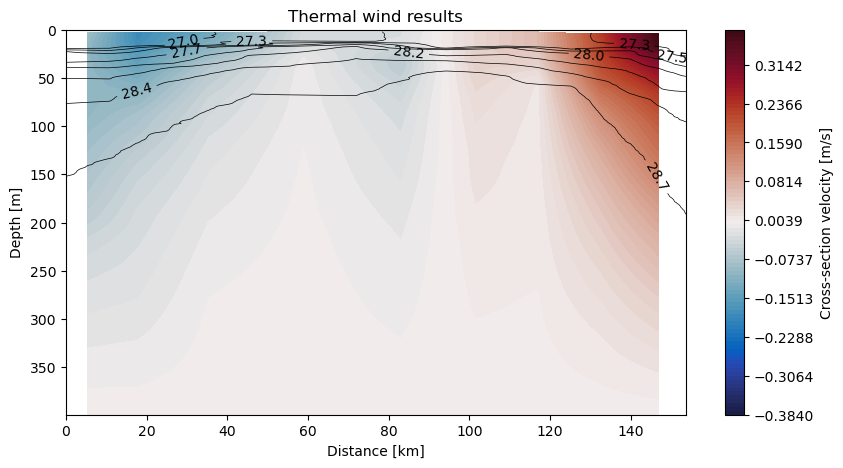

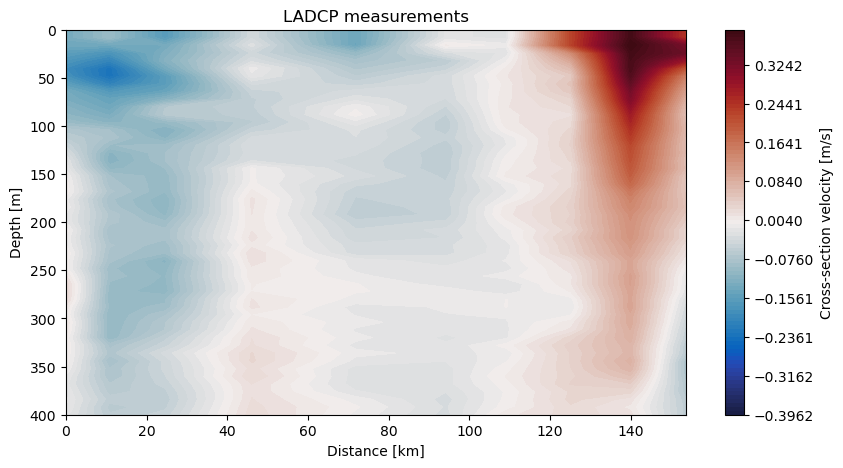

In [8]:
ds = get_CTD(2019)
ds = ds.where(ds.idx.isin(list(range(22,25)) + list(range(33,40))), drop=True).sel(depth=slice(0, 400))
ds_LADCP = get_LADCP(2019)
ds_LADCP = ds_LADCP.where(ds_LADCP.idx.isin(list(range(21,24)) + list(range(32,39))), drop=True).sel(depth=slice(0, 400))
show_section(ds, ds_LADCP)